# Damped Newton's Method: Variants

Gabriel Konar-Steenberg, 2022-11-08

## Problem Statement

We first note the definition of the analytic centering problem in Boyd problem 9.30:
$$\text{minimize}\quad f(x) = -\sum_{i=1}^m \log(1-a_i^T x) - \sum_{i=1}^n \log(1-x_i^2)$$
for $x \in \mathbb{R}^n$.

Now, recall Newton's (damped) method:
$$ \vec x_{k+1} = \vec x_k - t((\text{Hess}\ f)(\vec x_k))^{-1} \nabla f(\vec x_k) $$
where $t$ is a step size found by backtracking line search.
Boyd problem 9.31a introduces a method we will call the "N-lazy Newton's method," which is defined as
$$ \vec x_{k+1} = \vec x_k - t (H^{-1} \nabla f(\vec x_k)) $$
where $H$ is the Hessian evaluated only once every $N$ iterations.

Now, Boyd's "Additional Exercises" 8.4 can be understood as pointing out a way of computing the N-lazy Newton's method using the Cholesky factorization:
$$ \vec x_{k+1} = \vec x_k - t ((L^*)^{-1} L^{-1} \nabla f(\vec x_k)) $$
where $H=LL^*$ is the Cholesky factorization of $H$. Using the backslash operator as defined in Matlab, this is the same as
$$ \vec x_{k+1} = \vec x_k - t (L^* \backslash (L \backslash \nabla f(\vec x_k)))\text{.}$$

Boyd "Additional Exercises" 8.4 then asks us to apply the Cholesky-optimized N-lazy Newton's method to the analytic centering problem with $N = 1$, $N = 15$, and $N = 30$ and graph the performance, taking a computational cost of $n^3/3$ for each call to the Cholesky factorization routine and $2n^2$ for each use of the procedure with two backslashes in it.

## Solution

We begin with a function to generate instances of the problem as suggested in extra problems 8.3, where $A$ is the matrix formed by taking the various $\vec a_i$ vectors as row vectors:

In [1]:
import numpy as np

n=100
m=200
def get_A(my_n=None, my_m=None, seed="GabrielKS"):
    if my_n is None: my_n = n
    if my_m is None: my_m = m
    if seed is not None: np.random.seed(hash(seed) & 0xFFFFFFFF)  # Turn any type of seed into a 32-bit integer
    return np.random.randn(my_m, my_n)

get_A()

array([[ 0.79645722, -0.08698405,  1.25703053, ...,  0.45847555,
         0.09243953,  0.78997074],
       [-0.21387505,  0.68007913, -0.44610217, ..., -0.97167447,
        -1.2905199 , -0.85921985],
       [ 2.34729151,  1.88029458, -0.6651619 , ...,  0.27069306,
        -1.26493417,  0.76723499],
       ...,
       [-0.83512937, -0.46617706, -1.25585256, ..., -1.08879008,
        -0.06931466,  0.44849661],
       [ 0.85339979, -0.54317865,  0.44428995, ..., -1.27014509,
        -0.79173405,  0.48779173],
       [ 0.19135862,  1.1180561 ,  0.40641943, ...,  0.64959339,
        -0.77588022,  0.14827205]])

Now, we need the gradient and Hessian of $f$. We compute these *a priori* using the chain rule and such for the general case, where the slash is Matlab- (or NumPy-) style element-wise division with broadcasting where it would otherwise be undefined:

$$\begin{align*}
f(x) &= -\sum_{i=1}^m \log(1-a_i^T x) - \sum_{i=1}^n \log(1-x_i^2)\text{,}\\

\nabla f(x) &= \nabla (-\sum_{i=1}^m \log(1-a_i^T x) - \sum_{i=1}^n \log(1-x_i^2))\\
    &= \nabla (-\sum_{i=1}^m \log(1-a_i^T x) - \sum_{i=1}^n \log(1+x_i) - \sum_{i=1}^n \log(1-x_i^2))\\
    &= A^T * 1/(1-Ax) - 1/(1+x) + 1/(1+x)\text{,}\\

(\text{Hess}\ f)(x) &= A^T \text{diag}(1/(1-Ax)^2)A + \text{diag}(1/(1+x)^2 + 1/(1-x)^2)\text{.}
\end{align*}$$
It is also important to note that
$$\mathbf{dom}\ f = \{x \mid a_i^T < 1, i = 1, \dots, m; |x_i| < 1, i = 1, \dots, n\}\text{,}$$
as Boyd problem 9.30 has it.

We now implement these formulas:

In [2]:
A = get_A()
x0 = np.zeros((n, 1))
print(A.shape)
print(x0.shape)

def gen_diag(x):  # Diagonalize when the input is a row or column vector rather than a 1d array
    return np.diag(x.reshape(-1))

def f(x):  # The given function itself
    return -np.sum(np.log(1-A@x))-np.sum(np.log(1-x**2))

def gf(x):  # Gradient of f
    return A.T@(1/(1-A@x)) - 1/(1+x) + 1/(1-x)

def hf(x):  # Hessian of f
    return A.T@gen_diag(1/(1-A@x)**2)@A + gen_diag(1/(1+x)**2 + 1/(1-x)**2)

def feasible(x):  # Is x in the domain of f?
    return max(A@x) < 1 and max(abs(x)) < 1

print(f(x0))
print(gf(x0).shape)
print(hf(x0).shape)

(200, 100)
(100, 1)
-0.0
(100, 1)
(100, 100)


We define some backtracking line searches:

In [3]:
def backtrack_generic(x, v, goal, beta = 0.5, t0=1, **kwargs):
    # Accept **kwargs so that we can blindly pass all the kwargs in when composing with this function
    t = t0
    while not goal(x+t*v, t): t *= beta
    return t

def backtrack_feasible(x, v, **kwargs):  # Do a backtracking line search for the area of feasibility
    goal = lambda pt, t: feasible(pt)
    return backtrack_generic(x, v, goal, **kwargs)

def backtrack_optimal(x, v, alpha=0.01, **kwargs):  # Do a standard backtracking line search
    goal = lambda pt, t: f(pt) <= f(x) + alpha*t*gf(x).T@v
    return backtrack_generic(x, v, goal, **kwargs)

And the steps to go from $L$ to search step and ~~win~~ end condition:

In [4]:
ldiv = np.linalg.solve  # Equivalent of Matlab's mldivide (backslash operator) for our purposes

def step_endcond_from_L(L, g):  # Returns (Newton step, (decrement squared over 2))
    ihessgrad = ldiv(L.T, ldiv(L, g))
    return -ihessgrad, g.T@ihessgrad/2

We are now ready to implement the Cholesky-optimized N-lazy Newton's method:

In [5]:
# Runs at most maxiters of the Cholesky-optimized N-lazy Newton's method with given N
# Stops if the end condition (a stand-in for the distance from the real optimal x) is less than epsilon
def cholesky_N_newton(N, maxiters = 1000, epsilon = 1e-9, **kwargs):
    # Initial values
    i = 0
    x = x0
    endcond = None
    t = None
    flops = 0

    # Things to log and their keys
    log_vars = lambda: {"x": x, "endcond": endcond, "t": t, "flops": flops}
    log = {k: [] for k in log_vars()}

    # Iteration
    while i < maxiters:
        # Recompute Hessian every N iterations
        if i % N == 0:
            H = hf(x)
            L = np.linalg.cholesky(H)
            flops += n**3/3
        
        # Compute step and end condition
        g = gf(x)
        v, endcond = step_endcond_from_L(L, g)
        flops += 2*n**2

        # Record current state
        this_log = log_vars()
        for k in this_log: log[k].append(this_log[k])

        if endcond < epsilon: break  # End if we're close enough

        # Find the best t by first constraining to the domain of f and then line searching
        t_feasible = backtrack_feasible(x, v, **kwargs)
        t = backtrack_optimal(x, v, t0 = t_feasible, **kwargs)

        # Update state
        x = x+t*v
        i += 1
    
    return log

Does it converge with $N=1$?

In [6]:
log = cholesky_N_newton(1)
print(log["endcond"])

[array([[42.26168587]]), array([[30.35131661]]), array([[11.58277828]]), array([[0.65270164]]), array([[0.01175421]]), array([[4.9784837e-05]]), array([[1.07559168e-09]]), array([[5.17952048e-19]])]


It does! Let's make some graphs with the recommended values of $N$.

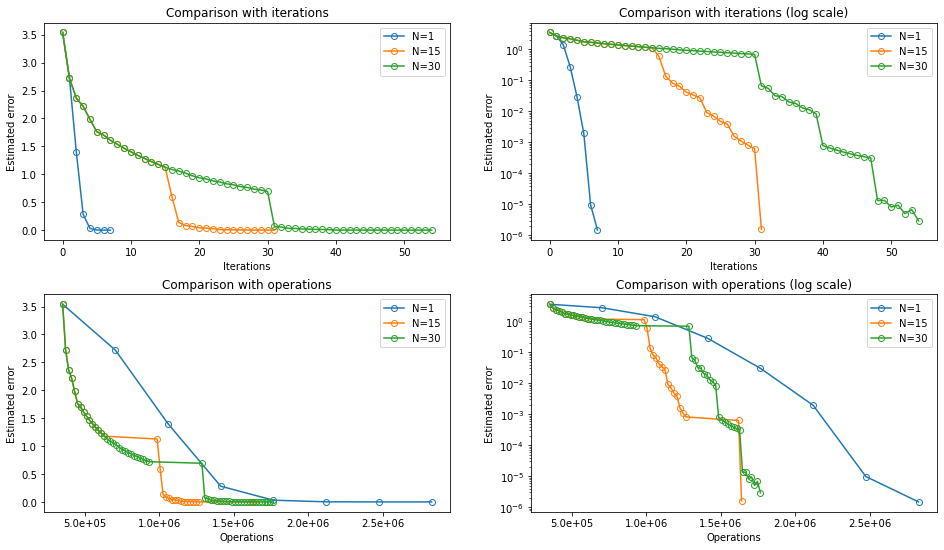

In [7]:
Ns = [1, 15, 30]
raw_results = {N: cholesky_N_newton(N) for N in Ns}
pstar = np.mean([result["x"][-1] for result in raw_results.values()], axis=0)  # Best guess at the true value is average of final values
for result in raw_results.values():
    result["err"] = np.linalg.norm(np.array(result["x"])-pstar, axis=1)
    result["i"] = list(range(len(result["err"])))

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
def do_plot_base(fig, ax, x_key, x_label, title):
    for k, result in raw_results.items():
        ax.plot(result[x_key], result["err"], "-o", markerfacecolor="none", label=f"N={k}")
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel("Estimated error")
    ax.set_title(title)

fig, axs = plt.subplots(2, 2, figsize=(16, 9))
fig.subplots_adjust(hspace=0.25)
do_plot_base(fig, axs[0, 0], "i", "Iterations", "Comparison with iterations")
axs[0, 1].set_yscale("log")
do_plot_base(fig, axs[0, 1], "i", "Iterations", "Comparison with iterations (log scale)")

axs[1, 0].xaxis.set_major_formatter(mtick.FormatStrFormatter("%.1e"))
do_plot_base(fig, axs[1, 0], "flops", "Operations", "Comparison with operations")
axs[1, 1].set_yscale("log")
axs[1, 1].xaxis.set_major_formatter(mtick.FormatStrFormatter("%.1e"))
do_plot_base(fig, axs[1, 1], "flops", "Operations", "Comparison with operations (log scale)")

plt.show()

We conclude that, while increasing $N$ increases the number of *iterations* needed to converge to within a certain tolerance, it decreases the number of total *computational operations* needed to do this.